#  Exploring residuals

TODO: Find a larger dataset, this one is not working out, perhaps because it's so small (or, my ideas are off base)

This notebook will explore the how model performance can be explored using residuals. There will also be an example on how we can then use this data to inform what data we may be needing.

As an example, we'll use the [scikit-learn diabetes](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html#sklearn.datasets.load_diabetes) dataset. 

This blog post has an excellent summary on residuals: https://towardsdatascience.com/how-to-use-residual-plots-for-regression-model-validation-c3c70e8ab378

In [1]:
from sklearn import datasets
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
diabetes = datasets.load_diabetes(as_frame=True)
X, y = diabetes.data, diabetes.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [3]:
print(X_train.shape)
print(X_test.shape)

(331, 10)
(111, 10)


Simple validation of the data's completeness:

In [4]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331 entries, 20 to 172
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     331 non-null    float64
 1   sex     331 non-null    float64
 2   bmi     331 non-null    float64
 3   bp      331 non-null    float64
 4   s1      331 non-null    float64
 5   s2      331 non-null    float64
 6   s3      331 non-null    float64
 7   s4      331 non-null    float64
 8   s5      331 non-null    float64
 9   s6      331 non-null    float64
dtypes: float64(10)
memory usage: 28.4 KB


In [5]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111 entries, 362 to 437
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     111 non-null    float64
 1   sex     111 non-null    float64
 2   bmi     111 non-null    float64
 3   bp      111 non-null    float64
 4   s1      111 non-null    float64
 5   s2      111 non-null    float64
 6   s3      111 non-null    float64
 7   s4      111 non-null    float64
 8   s5      111 non-null    float64
 9   s6      111 non-null    float64
dtypes: float64(10)
memory usage: 9.5 KB


## Model performance 

Now that we have the raw data, we can see how a basic model performs. As you can see, it's quite overfit (perfect prediction is a score of 1).

In [6]:
from sklearn.model_selection import RandomizedSearchCV
def random_forest_grid_search():
  return RandomizedSearchCV(RandomForestRegressor(random_state=0), {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)],
               'max_features':  ['auto', 'sqrt', 0.75, 0.5, 0.25],
               'max_depth': [int(x) for x in np.linspace(1, 110, num = 10)],
               'min_samples_split':  [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap':  [True, False]}, random_state=0, cv=3,  n_jobs=-1, verbose=1, n_iter=10)

In [7]:
model = random_forest_grid_search()
model = model.fit(X_train, y_train)
model.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomForestRegressor(max_depth=85, max_features='sqrt', min_samples_split=10,
                      n_estimators=944, random_state=0)

In [8]:
print(f"Recall score: {model.score(X_train, y_train)}")
print(f"Cross validation data score: {model.score(X_test, y_test)}")

Recall score: 0.8133270964704185
Cross validation data score: 0.2936151133317063


# Analyzing residuals

We can predict values on our held out dataset and calculate the residual as the predicted value - the expected value.

In [9]:
initial_predictions = model.predict(X_test)

In [10]:
initial_residuals = y_test - initial_predictions

In [11]:
initial_residuals

362    79.618610
249   -20.441375
271   -40.483540
435   -45.867750
400     3.177966
         ...    
325   -30.031175
366   -18.981210
22    -38.571985
68     71.538019
437   -66.241437
Name: target, Length: 111, dtype: float64

The residuals are not clearly grouped, let's go ahead and plot the values and see if we have random error, or some type of pattern.

[Text(0, 0.5, 'initial_residual'), Text(0.5, 0, 'expected')]

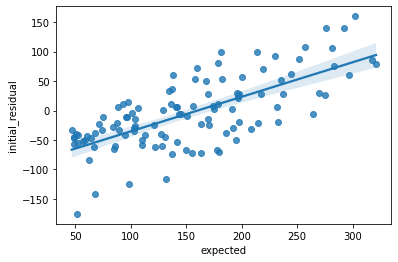

In [12]:
import seaborn as sns
sns.regplot(x=y_test, y=initial_residuals).set(xlabel='expected', ylabel='initial_residual')

As you can see in the plot above, the residual is not good. The line of fit should be roughly a horizontal line around zero, indicating that all values are due to noise. We are not capturing enough predictive information to make a good call.

Something to consider is that the model is quite overfit, but I'm not sure that's something that is contributing to this result.

Something I'm noticing is that the line has a higher residual amount when the expected value is high, and a lower amount when the expected value is low. Therefore, it's likely that the line of best fit of expected v actual would not be a line of the equation y = x.

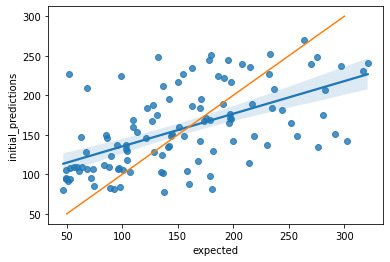

In [13]:
sns.regplot(x=y_test, y=initial_predictions).set(xlabel='expected', ylabel='initial_predictions')
sns.lineplot(x=[50, 300], y=[50, 300])

Sure enough, it looks like it's far from the optimal line.

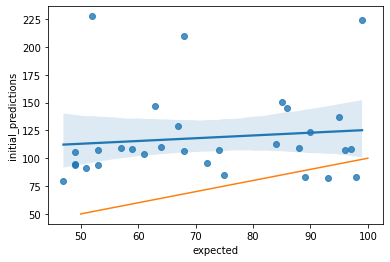

In [14]:
sns.regplot(x=y_test[y_test< 100], y=initial_predictions[y_test< 100]).set(xlabel='expected', ylabel='initial_predictions')
sns.lineplot(x=[50, 100], y=[50, 100])

Sure enough, this makes it much more clear that we don't get to any values below ~75, which is obviously wrong. 

If we were to simulate some data at the lower bounds, then perhaps we'll see better performance.

# Improving model performance using residual analysis

Just doing a bit of data analysis. The data is centered & neatly scaled.

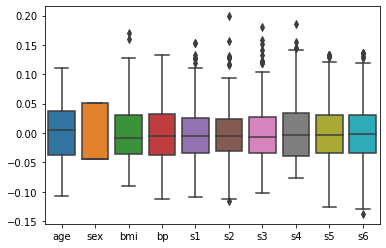

In [15]:
sns.boxplot(data=X_train)

In addition, some features appear to be much more correlated with the progression of diabetes than others, which almost look like a vertical line would fit it best.

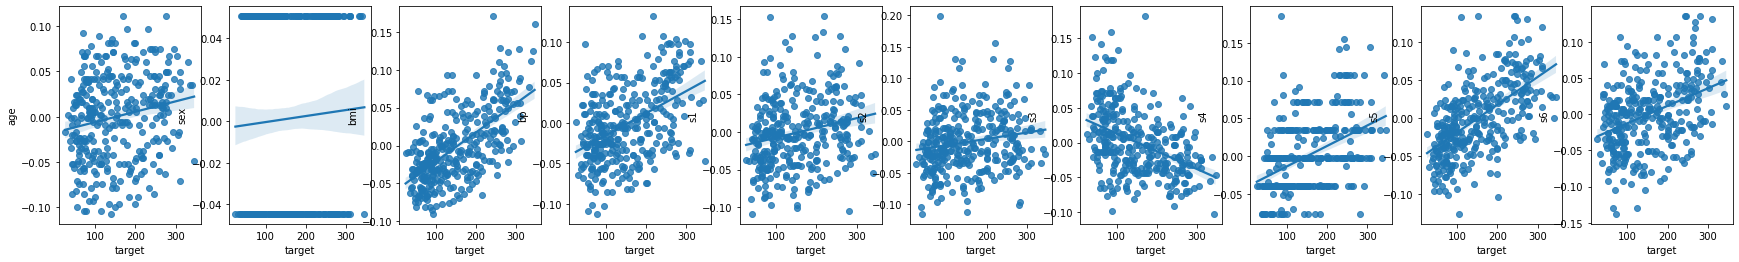

In [16]:
fig, ax =plt.subplots(1, len(X_train.columns), figsize=(30, 4))
for idx, col in enumerate(X_train.columns):
  sns.regplot(x=y_train, y=X_train[col], ax=ax[idx])
fig.show()


Interestingly, the residual graphs for each of the input columns seems to be quite optimal around 0.

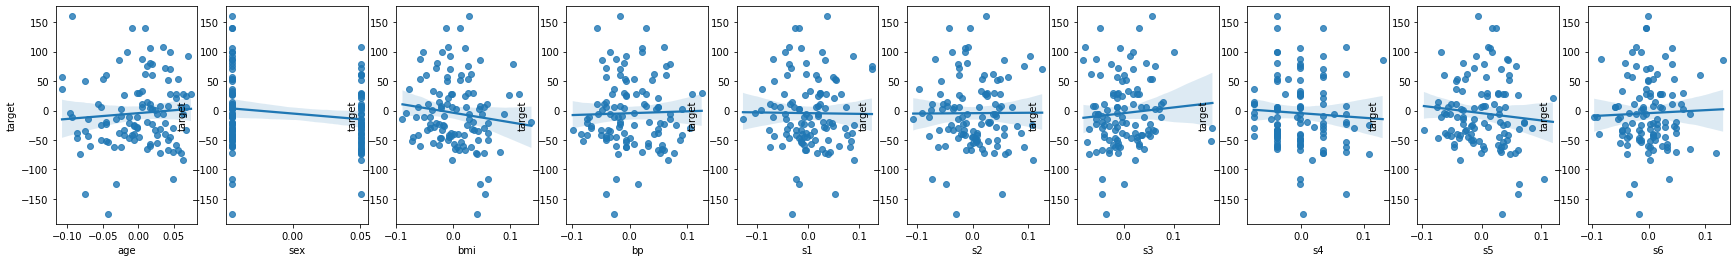

In [18]:
fig, ax =plt.subplots(1, len(X_train.columns), figsize=(30, 4))
for idx, col in enumerate(X_train.columns):
  sns.regplot(x=X_test[col], y=initial_residuals, ax=ax[idx])
fig.show()


All of the residual graphs look fairly OK. There is a pretty even distribution of residual values across the input features. There is no one feature that is performing better or worse than others. 

## Augment the data

In [19]:
combined_data = X_train.copy()
combined_data["labels"] = y_train

lower_bound = 100
lower_bound_data =  combined_data[combined_data["labels"] < lower_bound]

In [20]:
lower_bound_data.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,labels
count,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000
mean,-0.010087,-0.001089,-0.029667,-0.021698,-0.014166,-0.013099,0.023329,-0.023480,-0.032390,-0.019824,70.293103
std,0.044236,0.047689,0.033870,0.038773,0.043229,0.045236,0.050373,0.040398,0.034267,0.041570,17.626569
min,-0.103593,-0.044642,-0.090275,-0.112400,-0.108893,-0.115613,-0.098625,-0.076395,-0.101644,-0.137767,25.000000
25%,-0.041840,-0.044642,-0.055785,-0.044403,-0.043192,-0.041867,-0.013948,-0.039493,-0.058218,-0.047676,57.250000
50%,-0.001882,-0.044642,-0.032073,-0.026328,-0.015328,-0.016345,0.019187,-0.039493,-0.033249,-0.021788,71.000000
75%,0.019913,0.050680,-0.011326,0.001215,0.007031,0.010899,0.056003,-0.002592,-0.010904,0.007207,85.000000
max,0.092564,0.050680,0.071397,0.097616,0.152538,0.198788,0.159089,0.185234,0.089899,0.106617,99.000000


In [21]:
from numpy.random import default_rng
rng = default_rng()
noise = rng.standard_normal(lower_bound_data.shape)
print("noise range", noise.min(), noise.max())
noise = noise / 500  # The data is quite small, we don't want to loose the nuance
print("noise range", noise.min(), noise.max())

noise range -3.9739379034694062 2.763627832153529
noise range -0.007947875806938813 0.005527255664307057


In [22]:
full_aumented_df = lower_bound_data + noise

In [23]:
full_aumented_df.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,labels
count,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000
mean,-0.010260,-0.001307,-0.029840,-0.021507,-0.014045,-0.012824,0.023214,-0.023036,-0.032259,-0.019584,70.293359
std,0.044284,0.048143,0.033923,0.038467,0.043444,0.045276,0.050299,0.040526,0.034132,0.041452,17.626591
min,-0.103778,-0.050904,-0.090997,-0.111908,-0.108772,-0.116493,-0.099857,-0.079368,-0.101334,-0.138128,24.999462
25%,-0.038955,-0.045397,-0.057333,-0.045482,-0.041934,-0.041199,-0.012918,-0.040188,-0.058511,-0.048677,57.249470
50%,-0.003929,-0.041879,-0.032639,-0.025846,-0.015772,-0.017392,0.017622,-0.037105,-0.032773,-0.019512,71.002503
75%,0.019380,0.050692,-0.013268,0.001094,0.006934,0.011114,0.054101,-0.002705,-0.011399,0.006754,85.000745
max,0.095159,0.054695,0.068458,0.097760,0.149237,0.198926,0.155734,0.185377,0.087208,0.108942,98.996156


In [24]:
augmented_train_labels = full_aumented_df["labels"]
augmented_train_data = full_aumented_df.drop("labels", axis=1)


In [25]:
modified_train_labels = pd.concat((augmented_train_labels, y_train))
modified_train_data = pd.concat((augmented_train_data, X_train))

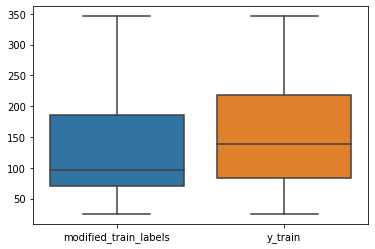

In [26]:
sns.boxplot(data=[modified_train_labels, y_train])
plt.xticks(plt.xticks()[0], ["modified_train_labels", "y_train"])
plt.show()

In [27]:
X_train = modified_train_data
y_train = modified_train_labels

### Re-train the model using new data

In [28]:
model = random_forest_grid_search()
model = model.fit(X_train, y_train)
model.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomForestRegressor(max_depth=85, max_features=0.5, min_samples_leaf=2,
                      min_samples_split=5, n_estimators=1788, random_state=0)

In [29]:
print(f"Recall score: {model.score(X_train, y_train)}")
print(f"Cross validation data score: {model.score(X_test, y_test)}")

Recall score: 0.9093206058178729
Cross validation data score: 0.24546133611653376


In [30]:
updated_predictions = model.predict(X_test)

In [31]:
updated_residuals = y_test - updated_predictions

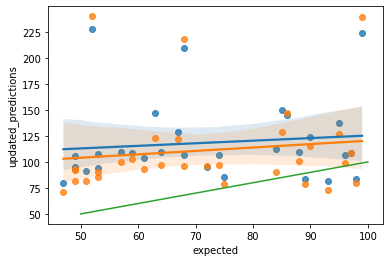

In [32]:
sns.regplot(x=y_test[y_test< lower_bound], y=initial_predictions[y_test< lower_bound]).set(xlabel='expected', ylabel='initial_predictions')
sns.regplot(x=y_test[y_test< lower_bound], y=updated_predictions[y_test< lower_bound]).set(xlabel='expected', ylabel='updated_predictions')
sns.lineplot(x=[50, lower_bound], y=[50, lower_bound])

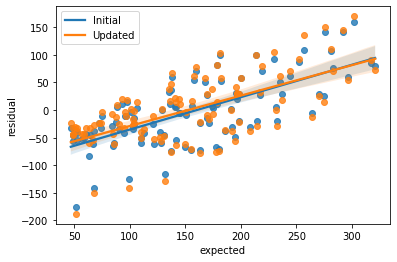

In [33]:
sns.regplot(x=y_test, y=initial_residuals)
sns.regplot(x=y_test, y=updated_residuals).set(xlabel='expected', ylabel='residual')
plt.legend(labels=["Initial","Updated"])

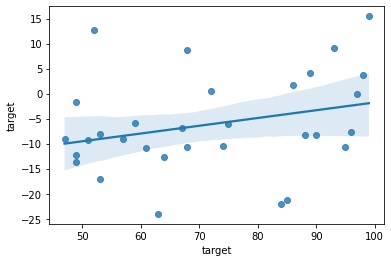

In [34]:
sns.regplot(x=y_test[y_test < lower_bound], y=(np.abs(updated_residuals[y_test < lower_bound]) - np.abs(initial_residuals[y_test < lower_bound])))